#### Outputs a **.csv** file with metrics on repositories from the following organizations:
- googlesamples
- aws-samples
- Azure-Samples
- spring-guides 
- googlearchive
- spring-cloud-samples
-spring-io
#### The metrics include:
- full_name
- name
- owner
- html_url
- description
- created_at
- updated_at
- pushed_at
- size
- language
- forks_count
- stargazers_count
- subscribers_count
- watchers_count
- network_count
- archived
- total_lines
- langs_percentage
<div class="alert alert-box alert-info">
    <b>Note:</b> You can change the organizations by modifying the list of organizations in the code cell below.
</div>

In [1]:
ORGANIZATIONS = [
    "googlesamples",
    "aws-samples",
    "Azure-Samples",
    "googlearchive",
    "spring-guides",
    "spring-cloud-samples",
    "spring-io"
]

EXCLUDED_REPOS = [
    "googlearchive/digits-migration-helper-android",
    "googlearchive/play-apk-expansion",
    "googlearchive/tiger",
    "googlearchive/two-token-sw",
    "googlearchive/Abelana-Android",
    "googlearchive/solutions-mobile-backend-starter-java"
]

In [2]:
%pip install PyGithub python-dotenv pandas tqdm cachetools matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
from github import Github
import pandas as pd
from dotenv import load_dotenv
from os import getenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
from cachetools import cached, TTLCache

In [4]:
load_dotenv()
g = Github(getenv('GITHUB_TOKEN'), per_page=100)

In [5]:
def fetch_organization_repositories(organization_name, language=None):
    repo_data = []
    organization = g.get_organization(organization_name)
    repos = organization.get_repos("all")
    total_repos = repos.totalCount

    def process_repo(repo):
        if repo.full_name in EXCLUDED_REPOS:
            return None
        if language and repo.language != language:
            return None
        if organization_name == "googlearchive" and not is_valid_googlearchive_repo(repo):
            return None
        elif organization_name == "SAP-samples" and not is_valid_sap_sample_repo(repo):
            return None
        
        repo_languages = repo.get_languages()
        total_lines = sum(repo_languages.values())
        language_percentages = {lang: f'{(lines/total_lines):.2%}' for lang, lines in repo_languages.items()}
        return {
        "full_name": repo.full_name,
        "name": repo.name,
        "owner": repo.owner.login,
        "html_url": repo.html_url,
        "description": repo.description, 
        "created_at": repo.created_at,
        "updated_at": repo.updated_at, 
        "pushed_at": repo.pushed_at,
        "size": repo.size, 
        "language": repo.language, 
        "forks_count": repo.forks_count,
        "stargazers_count": repo.stargazers_count, 
        "subscribers_count": repo.subscribers_count,
        "watchers_count": repo.watchers_count,
        "network_count": repo.network_count,
        "archived": repo.archived,
        "total_lines": total_lines,
        "langs_percentage": language_percentages
        }


    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_repo, repo) for repo in repos]
        for future in tqdm(as_completed(futures), total=total_repos, desc=organization_name, unit=" repos", ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}] {percentage:3.0f}%'):
            try:
                result = future.result()
                repo_data.append(result)
                    
            except Exception as e:
                print(f"Error fetching data for repo: {futures[future].full_name}, error: {e}")

    return pd.DataFrame(repo_data)

def is_valid_googlearchive_repo(repo):
    if not repo.description:
        return False
    keywords = ["example", "sample", "migrated"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

def is_valid_sap_sample_repo(repo):
    if not repo.description:
        return False
    keywords = ["cloud"]
    return any(keyword in repo.description.lower() for keyword in keywords) or any(keyword in repo.full_name.lower() for keyword in keywords)

<div class='alert alert-box alert-info'>
    Below is the code that generates the <b>.csv</b> metrics file.
    You can change the language by modifying the <i style='color: red'>language</i> variable in the code cell below.
</div>
<div class='alert alert-box alert-warning'>
    <b>Note:</b> The <i style='color: blue'>language</i> variable is case sensitive and can be <i style='color: blue'>None</i>, if you want to get all the repositories.
</div>

In [6]:

def generate_metrics_csv():
    all_repos_data = []
    
    def fetch_data_for_organization(organization):
        print(f'Retrieving repos from {organization}...')
        organization_repos_data = fetch_organization_repositories(organization, language=None)
        if not organization_repos_data.empty:
            return organization_repos_data
        else:
            return pd.DataFrame()

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_data_for_organization, org) for org in ORGANIZATIONS]
        for future in tqdm(as_completed(futures), desc="Processing organizations", unit=" orgs", total=len(ORGANIZATIONS), ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}] {percentage:3.0f}%'):
            org_data = future.result()
            if not org_data.empty:
                all_repos_data.append(org_data)

    all_repos_data_df = pd.concat(all_repos_data, ignore_index=True) if all_repos_data else pd.DataFrame()
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_path = f"results/codesamples_{timestamp}.csv"
    all_repos_data_df.to_csv(file_path, index=False)

    return all_repos_data_df

In [7]:
def calculate_language_usage(dataframe):
    language_usage = {}

    for repo in dataframe.itertuples():
        repo_languages = repo.langs_percentage
        total_lines = repo.total_lines

        for language, percentage in repo_languages.items():
            lines = total_lines * (float(percentage.strip('%')) / 100)
            language_usage[language] = language_usage.get(language, 0) + lines

    total_lines_of_code = sum(language_usage.values())

    formatted_languages = sorted(
        [(language, f'{(lines / total_lines_of_code):.2%}', int(lines)) for language, lines in language_usage.items()],
        key=lambda item: float(item[1].strip('%')),
        reverse=True
    )

    file_path = f"results/languages_usage.csv"
    dataframeLanguages = pd.DataFrame(formatted_languages, columns=["Language", "Usage Percentage", "Lines"])
    dataframeLanguages.to_csv(file_path, index=False)
    return dataframeLanguages


In [8]:
def generate_statistics(dataframe):
    numeric_metrics = dataframe[METRICS].select_dtypes(include='number')
    
    statistics = numeric_metrics.describe().transpose()
    
    statistics['median'] = numeric_metrics.median()
    statistics['mode'] = numeric_metrics.mode().iloc[0]
    
    file_path = f"results/statistics.csv"
    statistics.to_csv(file_path)
    
    return statistics

In [9]:
def plot_metrics_distribution(metricts):
    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metricts):
        plt.subplot(3, 3, i + 1)
        sns.histplot(dataframe[metric], kde=True, bins=30, color='blue', alpha=0.6)
        plt.axvline(dataframe[metric].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
        plt.axvline(dataframe[metric].median(), color='g', linestyle='dashed', linewidth=1, label='Median')
        plt.title(f'Distribution of {metric}')
        plt.xlabel(metric)
        plt.ylabel('Frequency')
        plt.legend()

    plt.tight_layout()
    plt.savefig('results/distribution_metrics.png')
    plt.show()

In [10]:
def plot_metrics_boxplot(metricts):
    numeric_metrics = dataframe[metricts].select_dtypes(include='number')
    
    plt.figure(figsize=(16, 12))
    for i, metric in enumerate(numeric_metrics.columns):
        plt.subplot(3, 3, i + 1)
        sns.boxplot(x=numeric_metrics[metric], color='lightblue')
        plt.title(f'Boxplot of {metric}')
        plt.xlabel(metric)
    
    plt.tight_layout()
    plt.savefig('results/boxplot_metrics.png')
    plt.show()

In [11]:
def plot_metrics_statistics(metricts):
    desc_stats = dataframe[metricts].describe().T[['mean', '50%', 'std']]
    desc_stats.columns = ['Mean', 'Median', 'Standard Deviation']
    desc_stats.plot(kind='bar', figsize=(12, 6))
    plt.title('Descriptive Statistics of Repository Metrics')
    plt.ylabel('Values')
    plt.xticks(rotation=0)
    plt.savefig('results/metrics_statistics.png')
    plt.show()

<div class='alert alert-box alert-info'>
    <h1>Results</h1>
    <p>The code cells below will generate a <b>.csv</b> file with the metrics of the repositories from the organizations mentioned above.</p>
</div>

In [12]:
METRICS = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count',
    'subscribers_count', 
    'network_count',
    'total_lines'
]

In [13]:
dataframe = generate_metrics_csv()
dataframe

Retrieving repos from googlesamples...
Retrieving repos from aws-samples...
Retrieving repos from Azure-Samples...
Retrieving repos from googlearchive...
Retrieving repos from spring-guides...
Retrieving repos from spring-cloud-samples...
Retrieving repos from spring-io...


Processing organizations:   0%|                                       | 0/7 [00:00<?, ? orgs/s]   0%Request GET /orgs/googlesamples failed with 403: Forbidden
Setting next backoff to 1546.815239s
Request GET /orgs/Azure-Samples failed with 403: Forbidden
Setting next backoff to 1546.800672s
Request GET /orgs/spring-cloud-samples failed with 403: Forbidden
Setting next backoff to 1546.800672s
Request GET /orgs/googlearchive failed with 403: Forbidden
Setting next backoff to 1546.785398s
Request GET /orgs/spring-io failed with 403: Forbidden
Request GET /orgs/spring-guides failed with 403: Forbidden
Setting next backoff to 1546.783641s
Setting next backoff to 1546.773998s
Request GET /orgs/aws-samples failed with 403: Forbidden
Setting next backoff to 1546.766805s


In [ ]:
dataframeLanguages = calculate_language_usage(dataframe)
dataframeLanguages

,Language,Usage Percentage,Lines
0,Java,71.17%,1151058
1,Shell,11.07%,178949
2,Groovy,6.09%,98445
3,Kotlin,4.91%,79406
4,JavaScript,3.49%,56519
5,HTML,2.74%,44298
6,Less,0.42%,6720
7,Dockerfile,0.07%,1063
8,Python,0.04%,646
9,Lua,0.01%,120


In [ ]:
dataframe_statistics = generate_statistics(dataframe)
dataframe_statistics

,count,mean,std,min,25%,50%,75%,max,median,mode
size,29.0,2952.206897,8238.879823,0.0,64.0,153.0,616.0,37077.0,153.0,0.0
stargazers_count,29.0,112.827586,161.337727,0.0,1.0,22.0,209.0,498.0,22.0,0.0
watchers_count,29.0,112.827586,161.337727,0.0,1.0,22.0,209.0,498.0,22.0,0.0
forks_count,29.0,112.275862,195.974652,1.0,5.0,19.0,109.0,891.0,19.0,5.0
subscribers_count,29.0,11.482759,11.014992,2.0,4.0,6.0,15.0,45.0,6.0,3.0
network_count,29.0,113.931034,195.424982,1.0,5.0,22.0,113.0,891.0,22.0,5.0
total_lines,29.0,55770.172414,135827.116053,0.0,1999.0,7597.0,59265.0,726505.0,7597.0,0.0


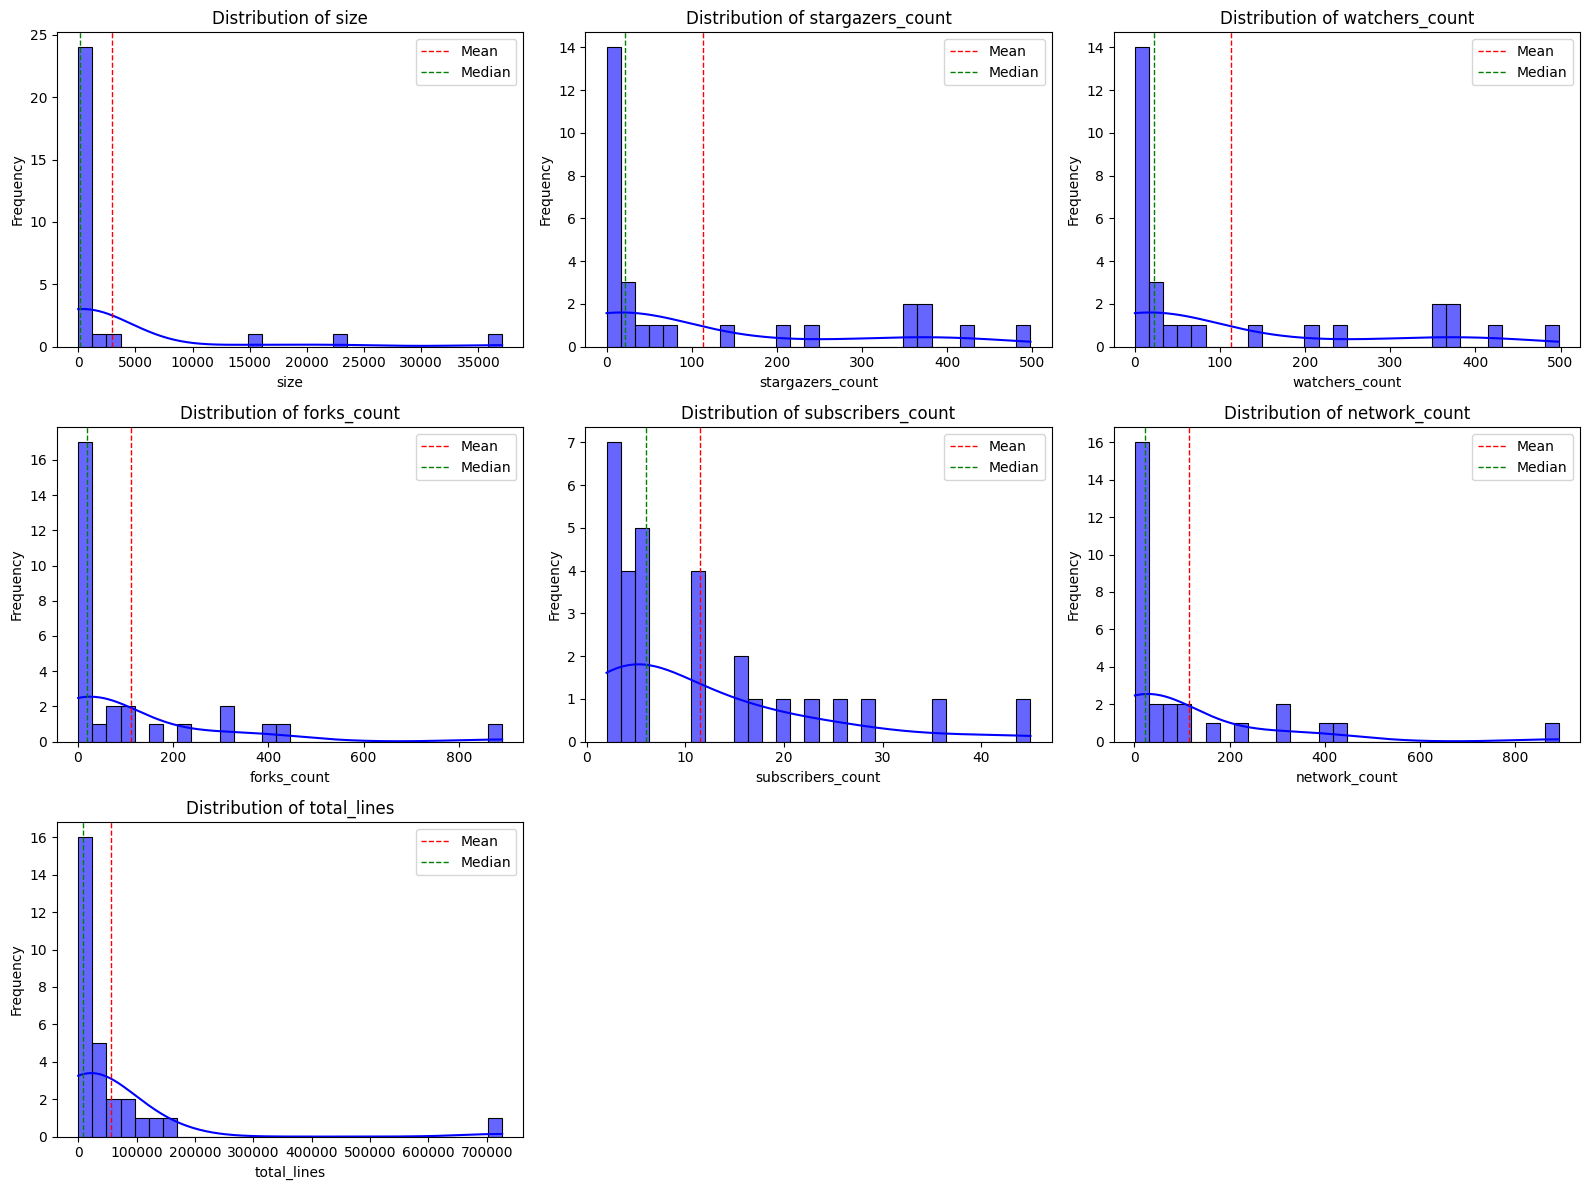

In [ ]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count',
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_distribution(metricts)

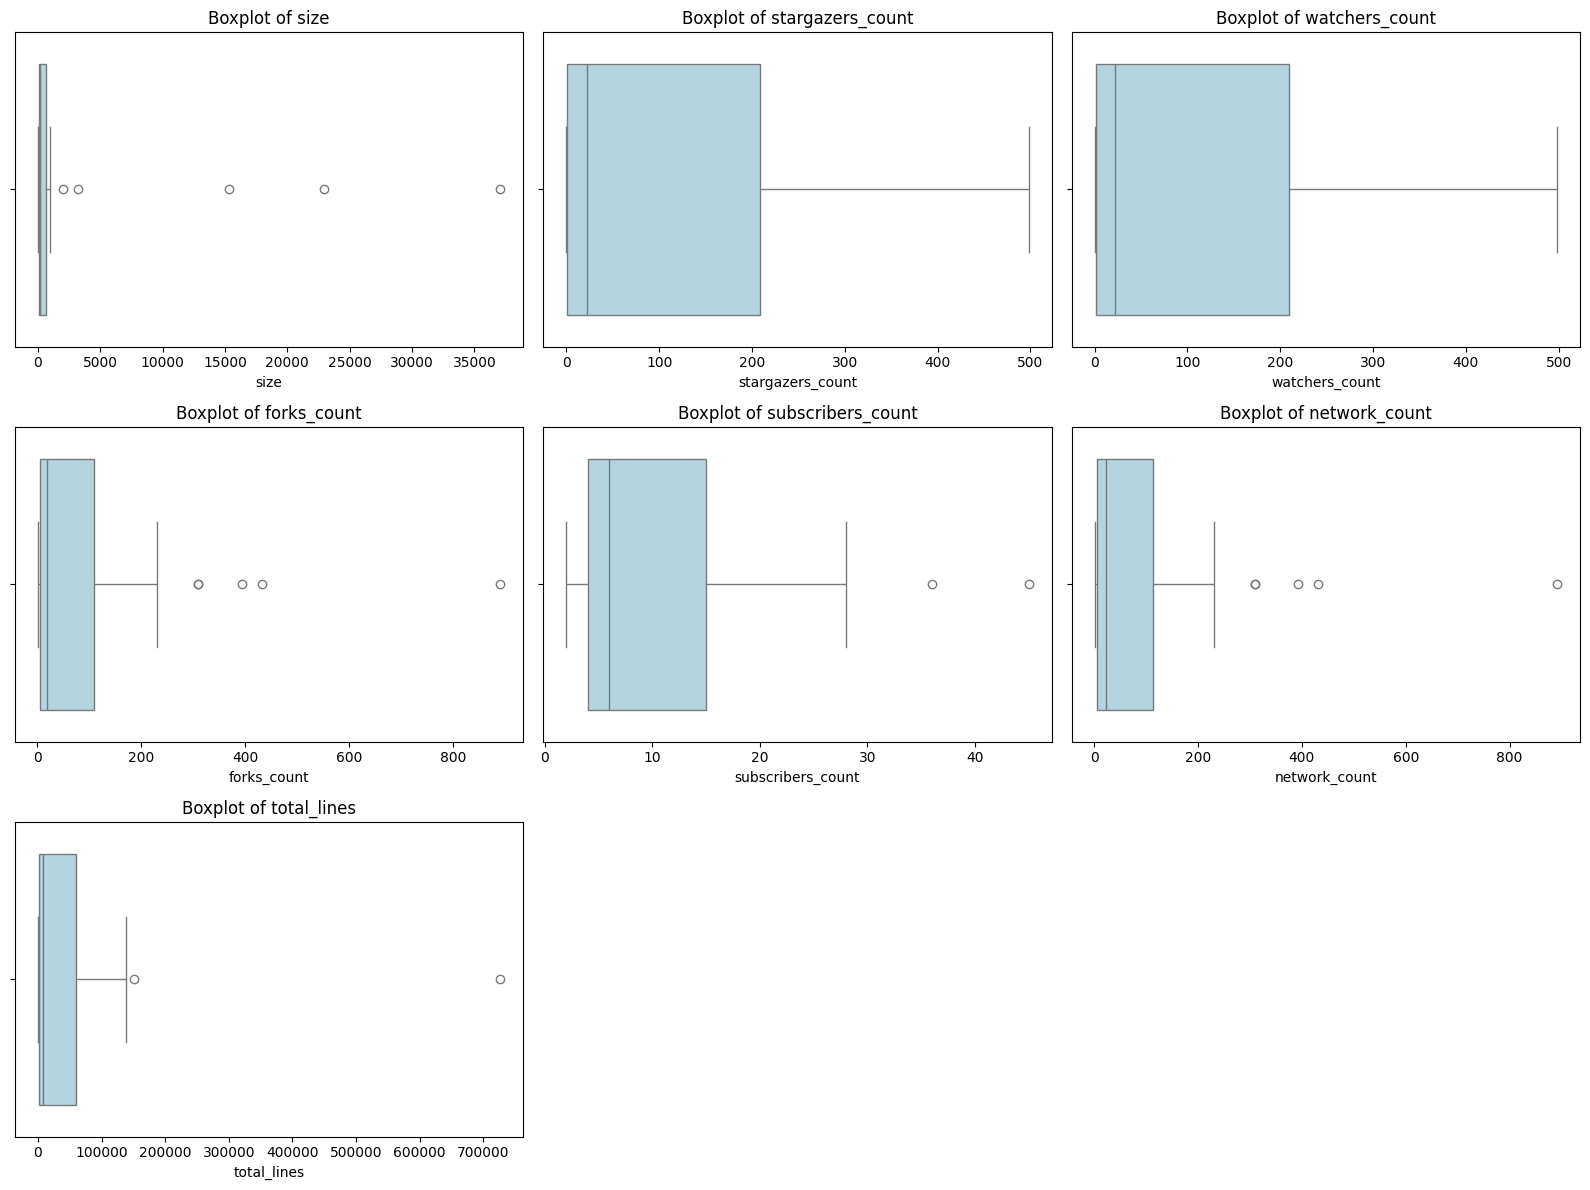

In [ ]:
metricts = [
    'size', 
    'stargazers_count', 
    'watchers_count', 
    'forks_count',
    'subscribers_count', 
    'network_count',
    'total_lines'
]
plot_metrics_boxplot(metricts)

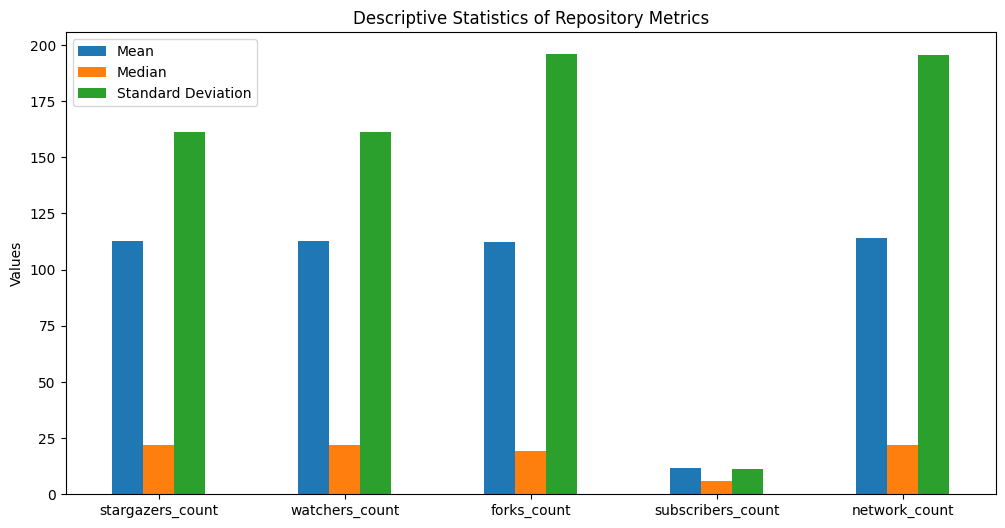

In [ ]:
metricts = [
    'stargazers_count', 
    'watchers_count', 
    'forks_count',
    'subscribers_count', 
    'network_count',
]
plot_metrics_statistics(metricts)